# SWEM (Simple Word Embedding-based Model)

Toma los embeddings y aplica operaciones de Pooling para obtener una representación fija de un documento
Se pueden emplear diferentes técnicas para obtener Embeddings y diferentes modelos de clasificación.

* SWEM-aver:
Hace un promedio de los embeddings

* SWEM-max
Selecciona el valor máximo en cada dimensión del embedding

In [1]:
import sys
import os
import pandas as pd

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.trainers.train_swem import train_swem
from src.trainers.utils import save_model
from src.trainers.utils import build_datasets, save_metrics
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES, TIKTOK_SWEM_METRICS_PATH

dataset_train, dataset_test, dataset_val = build_datasets(
    TIKTOK_DATASET_SENTENCES,
    test_size=0.3,
    val_size=0.5, # 0.5 de 0.3    
    random_state=42
)
print(dataset_train.shape)
print(dataset_test.shape)
print(dataset_val.shape)

(13727, 2)
(2942, 2)
(2942, 2)


In [ ]:
from src.preprocesamiento.nlp_spacy import Tokenizer

tokenizer = Tokenizer()

dataset_train_tokenized = {}
dataset_val_tokenized = {}
dataset_test_tokenized = {}

dataset_train_tokenized['tokens'] = tokenizer.tokenize(dataset_train['text'])
dataset_val_tokenized['tokens'] = tokenizer.tokenize(dataset_val['text'])
dataset_test_tokenized['tokens'] = tokenizer.tokenize(dataset_test['text'])

dataset_train_tokenized['polarity'] = dataset_train['polarity']
dataset_val_tokenized['polarity'] = dataset_val['polarity']
dataset_test_tokenized['polarity'] = dataset_test['polarity']

Modelo cargado: es_core_news_sm


100%|██████████| 2942/2942 [00:02<00:00, 1190.28it/s]


## Entrenar con modelo SVM

In [4]:
from src.trainers.utils import SVMModelArgs
from constants.constants_tiktok import EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

svm_model_args = SVMModelArgs()

### Hiperparámetros

In [5]:
import numpy as np

list_pooling = ["aver", "max"]
list_kernel = ["linear", "rbf", 'poly']
list_C = np.logspace(-2, 1, 20)
print(list_C)

[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]


In [6]:
for pooling in list_pooling:
    for kernel in list_kernel:
        for C in list_C:
            svm_model_args.kernel = kernel
            svm_model_args.C = C
            model, metrics = train_swem(
                dataset_train_tokenized,
                dataset_val_tokenized,
                embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
                pooling=pooling,
                classifier="svm",
                model_args=svm_model_args
            )
            print(f"SWEM SVM {pooling} {kernel} {C}: {metrics['accuracy']}")
            # Guardar Pipeline
            save_metrics(metrics, TIKTOK_SWEM_METRICS_PATH)

SWEM SVM aver linear 0.01: 0.600951733514616
SWEM SVM aver linear 0.01438449888287663: 0.6067301155676411
SWEM SVM aver linear 0.0206913808111479: 0.6097892590074779
SWEM SVM aver linear 0.029763514416313176: 0.6108089734874235
SWEM SVM aver linear 0.04281332398719394: 0.6091094493541809
SWEM SVM aver linear 0.06158482110660264: 0.6131883072739633
SWEM SVM aver linear 0.08858667904100823: 0.6145479265805575
SWEM SVM aver linear 0.12742749857031335: 0.6135282121006118
SWEM SVM aver linear 0.18329807108324356: 0.6148878314072059
SWEM SVM aver linear 0.26366508987303583: 0.6152277362338545
SWEM SVM aver linear 0.37926901907322497: 0.6138681169272604
SWEM SVM aver linear 0.5455594781168517: 0.6128484024473148
SWEM SVM aver linear 0.7847599703514611: 0.6121685927940177
SWEM SVM aver linear 1.1288378916846884: 0.6131883072739633
SWEM SVM aver linear 1.623776739188721: 0.6125084976206662
SWEM SVM aver linear 2.3357214690901213: 0.6121685927940177
SWEM SVM aver linear 3.359818286283781: 0.6125

## Entrenar con modelo LR

In [7]:
from src.trainers.utils import LRModelArgs

lr_model_args = LRModelArgs()

### Hiperparámetros

In [8]:
import numpy as np

list_pooling = ["aver", "max"]
list_solver_l1 = ["saga"]
list_solver_l2 = ["lbfgs", "saga"]
list_C = np.logspace(-2, 1, 20)
print(list_C)

[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]


### Penalty L2

In [9]:
for pooling in list_pooling:
    for solver in list_solver_l2:
        for C in list_C:
            lr_model_args.penalty="l2" 
            lr_model_args.C = C
            lr_model_args.max_iter = 300
            lr_model_args.solver = solver
            
            model, metrics = train_swem(
                dataset_train_tokenized,
                dataset_val_tokenized,
                embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
                pooling=pooling,
                classifier="lr",
                model_args=lr_model_args
            )
            print(f"SWEM LR l2 {pooling} {solver} {C}: {metrics['accuracy']}")
            save_metrics(metrics, TIKTOK_SWEM_METRICS_PATH)

c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.01: 0.6091094493541809


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.01438449888287663: 0.610469068660775


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.0206913808111479: 0.6114887831407206


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.029763514416313176: 0.6084296397008837


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.04281332398719394: 0.6036709721278042


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.06158482110660264: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.08858667904100823: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.12742749857031335: 0.6050305914343984


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.18329807108324356: 0.6046906866077498


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.26366508987303583: 0.6046906866077498


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.37926901907322497: 0.6053704962610469


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.5455594781168517: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 0.7847599703514611: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 1.1288378916846884: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 1.623776739188721: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 2.3357214690901213: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 3.359818286283781: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 4.832930238571752: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 6.951927961775605: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver lbfgs 10.0: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.01: 0.6087695445275323


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.01438449888287663: 0.610469068660775


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.0206913808111479: 0.611148878314072


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.029763514416313176: 0.6077498300475866


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.04281332398719394: 0.6040108769544528


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.06158482110660264: 0.6040108769544528


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.08858667904100823: 0.6057104010876955


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.12742749857031335: 0.6053704962610469


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.18329807108324356: 0.6050305914343984


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.26366508987303583: 0.6053704962610469


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.37926901907322497: 0.6067301155676411


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.5455594781168517: 0.6057104010876955


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 0.7847599703514611: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 1.1288378916846884: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 1.623776739188721: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 2.3357214690901213: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 3.359818286283781: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 4.832930238571752: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 6.951927961775605: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 aver saga 10.0: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.01: 0.583956492182189


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.01438449888287663: 0.5819170632222977


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.0206913808111479: 0.5832766825288919


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.029763514416313176: 0.5815771583956492


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.04281332398719394: 0.5836165873555405


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.06158482110660264: 0.583956492182189


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.08858667904100823: 0.5825968728755948


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.12742749857031335: 0.5812372535690007


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.18329807108324356: 0.5808973487423521


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.26366508987303583: 0.580217539089055


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.37926901907322497: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.5455594781168517: 0.579537729435758


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 0.7847599703514611: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 1.1288378916846884: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 1.623776739188721: 0.5788579197824609


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 2.3357214690901213: 0.5788579197824609


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 3.359818286283781: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 4.832930238571752: 0.5791978246091094


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 6.951927961775605: 0.579537729435758


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max lbfgs 10.0: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.01: 0.5846363018354861


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.01438449888287663: 0.5825968728755948


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.0206913808111479: 0.5832766825288919


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.029763514416313176: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.04281332398719394: 0.5836165873555405


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.06158482110660264: 0.5846363018354861


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.08858667904100823: 0.5832766825288919


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.12742749857031335: 0.5819170632222977


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.18329807108324356: 0.5815771583956492


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.26366508987303583: 0.5815771583956492


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.37926901907322497: 0.5819170632222977


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.5455594781168517: 0.5808973487423521


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 0.7847599703514611: 0.5808973487423521


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 1.1288378916846884: 0.5805574439157036


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 1.623776739188721: 0.5805574439157036


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 2.3357214690901213: 0.5805574439157036


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 3.359818286283781: 0.5805574439157036


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 4.832930238571752: 0.580217539089055


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 6.951927961775605: 0.580217539089055


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l2 max saga 10.0: 0.5798776342624066


### Penalty L1

In [10]:
for pooling in list_pooling:
    for solver in list_solver_l1:
        for C in list_C:
            lr_model_args.penalty="l1" 
            lr_model_args.C = C
            lr_model_args.max_iter = 300
            lr_model_args.solver = solver
            
            model, metrics = train_swem(
                dataset_train_tokenized,
                dataset_val_tokenized,
                embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
                pooling=pooling,
                classifier="lr",
                model_args=lr_model_args
            )
            print(f"SWEM LR l1 {pooling} {solver} {C}: {metrics['accuracy']}")
            save_metrics(metrics, TIKTOK_SWEM_METRICS_PATH)

c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.01: 0.5445275322909585


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.01438449888287663: 0.5693405846363019


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.0206913808111479: 0.5788579197824609


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.029763514416313176: 0.5866757307953773


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.04281332398719394: 0.5975526852481305


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.06158482110660264: 0.6046906866077498


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.08858667904100823: 0.6057104010876955


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.12742749857031335: 0.6043507817811012


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.18329807108324356: 0.6053704962610469


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.26366508987303583: 0.6033310673011557


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.37926901907322497: 0.6053704962610469


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.5455594781168517: 0.6057104010876955


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 0.7847599703514611: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 1.1288378916846884: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 1.623776739188721: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 2.3357214690901213: 0.606050305914344


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 3.359818286283781: 0.6070700203942896


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 4.832930238571752: 0.6070700203942896


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 6.951927961775605: 0.6067301155676411


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 aver saga 10.0: 0.6063902107409925


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.01: 0.5316111488783141


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.01438449888287663: 0.5577838205302516


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.0206913808111479: 0.5628823929299797


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.029763514416313176: 0.5679809653297077


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.04281332398719394: 0.5730795377294358


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.06158482110660264: 0.5815771583956492


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.08858667904100823: 0.5825968728755948


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.12742749857031335: 0.5822569680489463


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.18329807108324356: 0.5781781101291639


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.26366508987303583: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.37926901907322497: 0.5819170632222977


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.5455594781168517: 0.5808973487423521


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 0.7847599703514611: 0.5822569680489463


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 1.1288378916846884: 0.5815771583956492


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 1.623776739188721: 0.5812372535690007


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 2.3357214690901213: 0.5812372535690007


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 3.359818286283781: 0.580217539089055


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 4.832930238571752: 0.5798776342624066


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 6.951927961775605: 0.580217539089055


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SWEM LR l1 max saga 10.0: 0.580217539089055


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Modelo con mayor accuracy

In [11]:
# Seleccionar los hiperparámetros que generan mayor accuracy
df_metrics = pd.read_csv(TIKTOK_SWEM_METRICS_PATH)

best_acc = df_metrics.loc[df_metrics['accuracy'].idxmax()]
print(best_acc)

accuracy           0.673691
recall             0.673703
precision          0.672362
f1_score            0.67211
model                  SWEM
classifier              svm
pooling                aver
penalty                 NaN
kernel                  rbf
regularization     1.623777
max_iter                NaN
solver                  NaN
embedding_dim           100
train_time        18.318303
Name: 34, dtype: object


In [12]:
from constants.constants_tiktok import SWEM_MODEL_PATH
from src.trainers.utils import SVMModelArgs, LRModelArgs
from constants.constants_tiktok import EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

model_args = None
if best_acc['classifier'] == "svm":
    model_args = SVMModelArgs()
    model_args.kernel = best_acc['kernel']
    model_args.C = best_acc['regularization']
if best_acc['classifier'] == "lr":
    model_args = LRModelArgs()
    model_args.penalty=best_acc['penalty'] 
    model_args.C = best_acc['regularization']
    model_args.max_iter = best_acc['max_iter']
    model_args.solver = best_acc['solver']

# Entrenar modelo
pipeline, metrics = train_swem(
    dataset_train_tokenized,
    dataset_val_tokenized,
    EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    pooling=best_acc['pooling'],
    classifier=best_acc['classifier'],
    model_args=model_args
)

save_model(pipeline, SWEM_MODEL_PATH)

Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl


Cargando modelo: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl

Simple Word Embedding-based Model
Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1045
           1       0.57      0.64      0.60       868
           2       0.75      0.71      0.73      1029

    accuracy                           0.67      2942
   macro avg       0.67      0.67      0.67      2942
weighted avg       0.68      0.67      0.67      2942

Matriz de confusión


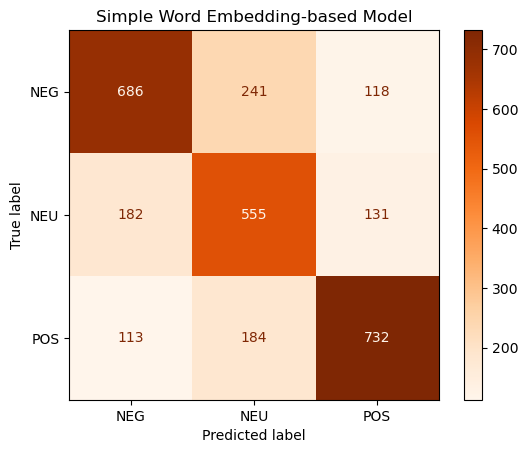

{'accuracy': 0.6706322229775663, 'recall': 0.6705967810161781, 'precision': 0.6690768380643991, 'f1_score': 0.6687346686013274}


In [13]:
from src.trainers.train_swem import evaluate_model
from src.trainers.utils import load_model

# Evaluar modelo con datos de prueba
model = load_model(SWEM_MODEL_PATH)
metrics = evaluate_model(
    model, 
    dataset_test_tokenized,
    "Simple Word Embedding-based Model",
    EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    best_acc['pooling'],
    )
print(metrics)